In [2]:
import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils import shuffle
from IPython import display

In [3]:
# Assign home_dir as a local directory to use when saving data to disk.
home_dir = os.getenv("home_BA885")
#
if not home_dir:
    home_dir = os.getcwd()
# Colab home
# home_dir = "/content/"

# Transfer Learning

Author: Nima Doroud

One of the most important resources for Deep Learning are tried and tested pretrained models which can be utilized in a variety of ways ranging from direct incorporation in a pipeline to drawing inspiration in architecture design. Aterall, pretrained models aren't just trained weights and biases but also model architectures and hyperparameters which are tuned to best extract information from a particular type of data.

Crucially, the latter part is task-specific rather than data-specific. For example, a model trained to recognize wildlife in images is really designed and tuned to pick up on objects and learn their features. In turn, this enables the transfer of specific application -- recognizing wildlife -- to a new domain, say recognizing household object.

This process, known as transfer learning, eliminates the need for designing and tuning a neural network from scratch and to a great extent reduces the time and resources needed for training.

To see this in action we will utilize transfer learning to produce a model that can detect speech commands starting with the pretrained [YAMNet](https://github.com/tensorflow/models/tree/master/research/audioset/yamnet) model.

## Speech commands dataset

We will use the "speech commands" dataset published by Peter Warden in conjunction with the paper [1804.03209](https://arxiv.org/abs/1804.03209).

The links for downloading the full dataset can be found [here](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/speech_commands/speech_commands_dataset_builder.py).

This dataset is also available through pardata:
```
import pardata
pardata.load_dataset('tensorflow_speech_commands')
```

In [ ]:
# Check if home_dir/dataset exists and if not create dataset directory.
if not os.path.exists(home_dir+'/datasets'):
    os.mkdir('datasets')
#
# Download links for train and test datasets.
ds_links = {'train' : 'http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
            'test' : 'http://download.tensorflow.org/data/speech_commands_test_set_v0.02.tar.gz'}
#
# Check if folder is already present
if os.path.exists(home_dir+'/datasets/speech_commands_train/'):
    raise ValueError("Folder exists already!")
# Download and extract train and test datasets.
for key in ds_links.keys():
    tf.keras.utils.get_file('speech_commands_{}.tar.gz'.format(key),
                            ds_links[key],
                            cache_dir = home_dir+'/datasets/',
                            cache_subdir = 'speech_commands_{}'.format(key),
                            extract=True)

In [7]:
# Train dataset directory
train_ds_dir = home_dir+'/datasets/speech_commands_train/'
#
# Create and populate a list of file paths for the train dataset.
train_paths = []
for folder, labels, samples in os.walk(train_ds_dir):
    for sample in samples:
        if sample[-3:] == 'wav':
            train_paths.append([folder+'/'+sample, folder[len(train_ds_dir):]])
#
# Convert the list to pandas.Dataframe
train_paths = pd.DataFrame(train_paths, columns=['file_path', 'category'])
#
# Number of samples per category
#data_paths.groupby('category').count()
#
# List the unique categories
train_paths['category'].unique()

array(['cat', 'wow', 'follow', 'yes', 'down', 'bird', 'marvin', 'right',
       'five', 'three', 'six', 'no', 'tree', 'off', 'four', 'bed', 'one',
       'zero', 'nine', 'eight', 'up', 'left', 'on', 'forward', 'learn',
       'dog', 'stop', '_background_noise_', 'seven', 'go', 'two',
       'sheila', 'visual', 'house', 'backward', 'happy'], dtype=object)

In [8]:
# Separate the '_background_noise_' category.
bg_noise_paths = train_paths.where(
    train_paths['category']=='_background_noise_').dropna()
train_paths = train_paths.where(
    train_paths['category']!='_background_noise_').dropna()
#
# Shuffle and reset the index of the dataframes
train_paths = train_paths.sample(frac = 1)
train_paths.reset_index(inplace=True)
#
bg_noise_paths = bg_noise_paths.sample(frac = 1)
bg_noise_paths.reset_index(inplace=True)
bg_noise_paths = np.array(bg_noise_paths['file_path'])
#
# Remaining number of categories
num_categories = train_paths['category'].unique().shape[0]
print('Number of distinct commands = {}'.format(num_categories))

Number of distinct commands = 35


In [9]:
# split into training (85%) and valididation (15%) datasets
split_index = train_paths.shape[0]*17//20
#
valid_labels = np.array(train_paths[split_index+1:]['category'])
valid_paths = np.array(train_paths[split_index+1:]['file_path'])
#
train_labels = np.array(train_paths[:split_index]['category'])
train_paths = np.array(train_paths[:split_index]['file_path'])
#
# Define the number of categories as a global parameter
num_categories = np.unique(train_labels).shape[0]

## Working with audio data

Before we get started with building a Neural Network, let's familiarize ourselves with audio data starting with how to import audio files as tensors as well as the standard representations of audio data (wave form and spectrogram with different scales).

### Audio data in wave form

In [10]:
# Define a function to import an audio file ('.wav') from disk as a
# tf.tensor with shape=(time*sample_rate, channel) if channels=True
# and shape=(time*sample_rate) otherwise.
def load_audio(file_path, l = 16000, sample_rate = 16000, channels = True):
    """Loads audio file from path assuming it has the provided sample rate.
    
    'file_path' is the path to the '.wav' file.
    
    'l' determines the shape of the output along the time axis (0).
    If desired_length = -1, the length is detemined by the length of the input.
    If the input file has length > desired_length it is truncated down to dl.
    If the input file has length < desired_length it is 0-padded at the end.
    
    'sample_rate' is the expected sample rate of the file.
    If the input file has a different sample rate the function raises an error.
    
    'channels' determines the rank of the output.
    If channels = True, the number of channels will match the input file
    (1 for mono, 2 for stereo, ...)
    If channels = False, the input is assumed to be mono audio and the channel
    axis is removed resulting in output_shape = (l,)
    
    Returns tf.tensor with float32 values in range [-1,1], with
    shape = (l, num_channels) if channels = True, else
    shape = (l,) if channels = False.
    """
    audio = tf.io.read_file(file_path)
    if not channels:
        audio, rate = tf.audio.decode_wav(audio,
                                          desired_channels = 1,
                                          desired_samples = l)
        audio = tf.squeeze(audio, axis=-1)
    else:
        audio, rate = tf.audio.decode_wav(audio,
                                          desired_channels = -1,
                                          desired_samples = l)
    if rate != sample_rate:
        raise ValueError('sample_rate does not match that of the input file.')
    return audio

In [31]:
# Here is a sample of audio data recording a spoken command.
sample_path = train_paths[0]
sample_audio = load_audio(sample_path)
# Here is a sample of audio data recording background noise.
sample_noise_path = bg_noise_paths[0]
sample_noise = load_audio(sample_noise_path)
#
print("Sample audio shape = {} and max_amplitude = {}".format(
    sample_audio.shape, tf.math.reduce_max(sample_audio)) + "\n"
      "Sample noise shape = {} and max_amplitude = {}".format(
          sample_noise.shape, tf.math.reduce_max(sample_noise))
     )

Sample audio shape = (16000, 1) and max_amplitude = 0.678192138671875
Sample noise shape = (16000, 1) and max_amplitude = 0.087127685546875


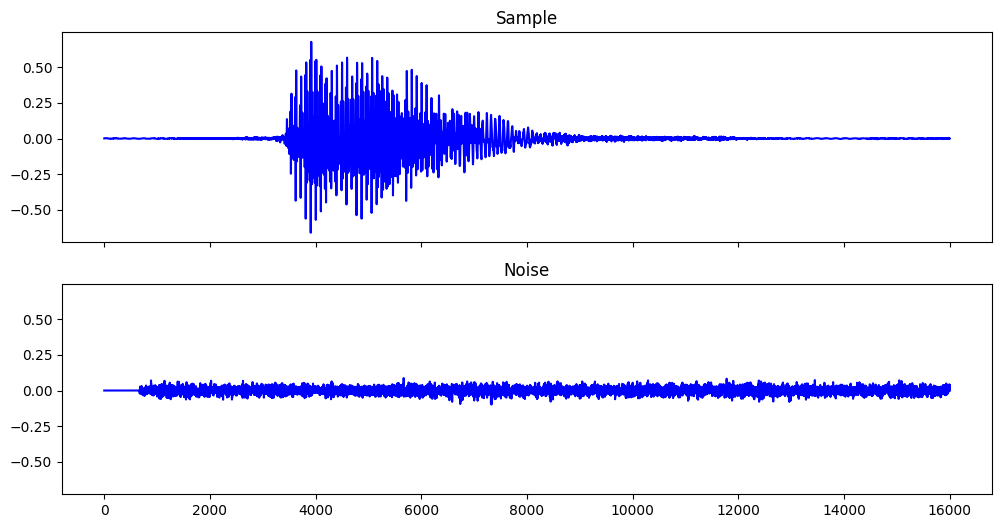

In [32]:
# Plot the wave forms (x ~ time, y ~ amplitude).
#
fig, axis = plt.subplots(2, sharex=True, sharey=True, figsize=(12, 6))
#
axis[0].plot(sample_audio.numpy().reshape((-1)), color='b')
axis[0].set_title('Sample')
#
axis[1].plot(sample_noise.numpy().reshape((-1)), color='b')
axis[1].set_title('Noise')
#
plt.show()

In [33]:
# To play the audio file directly in the notebook we can use
# Ipython.display:
display.Audio(sample_audio.numpy().reshape((-1)),rate=16000)

### Audio data in spectrogram form

Performing Short-time Fourier analysis on a waveform yields a spectrogram which is an all-round better feature representation of the data. Short-time Fourier transformation applies (truncated and discrete) Fourier transformation to a sliding window along the waveform mapping it to the stride(time)-frequency space.

amplitude(time, channel) --> amplitude(stride~time, frequency, channel)

We may further convert the frequency to mel scale (logarithmic frequency) or convert the amplitude to decibel (logarithmic amplitude) scale.

#### Hann (Gaussian) window

The common choice for the window is a Gaussian that fades the signal at the two ends, also known as Hann window. As we slide this window along the signal, Fourier transformation focuses on only the spectrum of the reduced signal.

In [34]:
def Hann_window(window_length = 4000, position = 0, length = 16000):
    """Generates a truncated Discrete Gaussian of length 'window_length'.
    The window is embedded in a sample of length 'length' starting
    at 'position'.
    Returns a tf.tensor of shape = ('length').
    """
    assert (window_length <= length
            and 0 <= position
            and position <= length - window_length)
    #
    window = tf.pad(tf.signal.hann_window(window_length),
                    tf.constant([[position, length - position - window_length]]),
                    "CONSTANT")
    return window

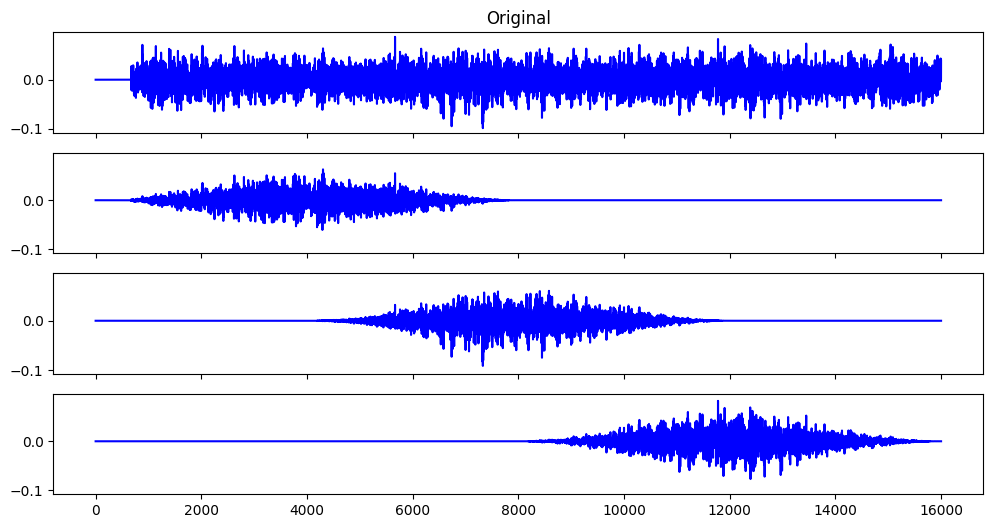

In [35]:
# Plot the wave forms (x = time, y = amplitude).
#
fig, axis = plt.subplots(4, sharex=True, sharey=True, figsize=(12, 6))
#
axis[0].plot(sample_noise.numpy().reshape((-1)), color='b')
axis[0].set_title('Original')
#
for i in np.arange(1, 4):
    axis[i].plot(np.multiply(Hann_window(8000, 4000*(i-1)).numpy(),
                             sample_noise.numpy().reshape((-1))),
                 color='b')
plt.show()

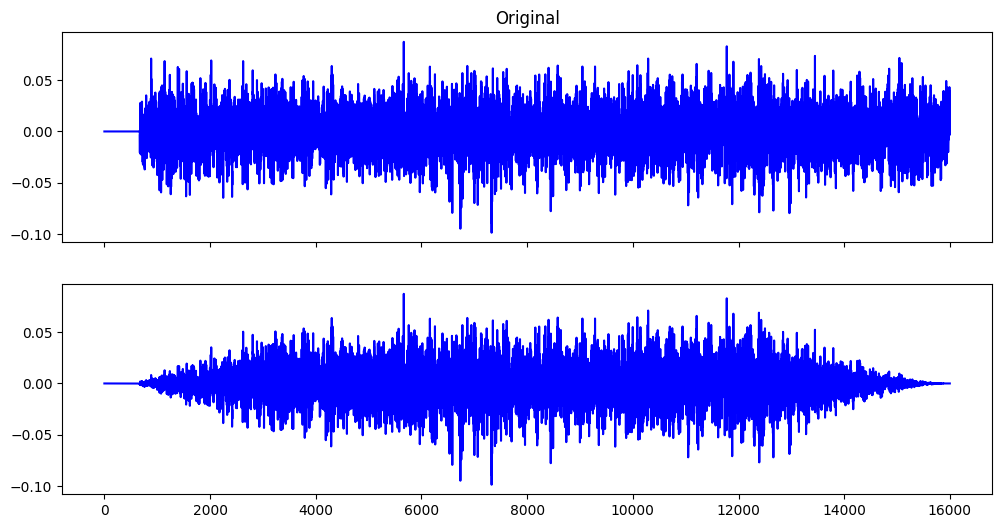

In [36]:
# Note, that with our choice of windows confined to the length of the
# signal the signal is automatically faded at the ends. If this is not
# the desired outcome we can pad the original signal by ~window_length/2
# on both ends.
#
fig, axis = plt.subplots(2, sharex=True, sharey=True, figsize=(12, 6))
#
axis[0].plot(sample_noise.numpy().reshape((-1)), color='b')
axis[0].set_title('Original')
#
axis[1].plot(np.sum([np.multiply(
    Hann_window(8000, 4000*(i-1)).numpy(), 
    sample_noise.numpy().reshape((-1))) for i in np.arange(1,4)],
                    axis=0),
                 color='b')
plt.show()

#### Spectrogram

Let us define a function to convert a waveform to a spectrogram.

In [37]:
# The built-in Fourier transform functions (from tf.signal) apply
# FT to the innermost dimension. If the waveform is in the channel
# last format we need to convert it to channel-first via the
# following function.
def convert_wave_to_channel_first(waveform):
    """Converts a signal with channel-last format to channel-first.
    Expects a tf.tensor of rank 2 (CT) or rank 3 (BCT).
    Returns a tf.tensor of the same shape where the inner axis is
    time. Example: Input format = BTC, output format = BCT.
    """
    if waveform.shape.rank == 2:
        perm = [1, 0]
    else:
        perm = [0, 2, 1]
    return tf.transpose(waveform, perm)
#
# We choose the convention where spectrograms are formated as
# frequency-stride-channel (FSC). This is not the output format of
# 'tf.signal.stft' but can be converted as follows.
def convert_spectrogram_to_frequency_first(spectrogram, channels = True):
    """Converts a spectrogram with the format '...(C)SF' (Stride-
    Frequency-Channel) to '...FS(C).
    """
    if channels:
        # Expected input format = (B)CSF
        if spectrogram.shape.rank == 3:
            perm = [2, 1, 0]
        else:
            perm = [0, 3, 2, 1]
    else:
        # Expected input format = (B)SF
        if spectrogram.shape.rank == 2:
            perm = [1, 0]
        else:
            perm = [0, 2, 1]
    return tf.transpose(spectrogram, perm)
#
# Define a function to generate a spectrogram in the FS(C) format from
# a waveform in the channel-last format.
def get_spectrogram(waveform, window, stride, fts, channels = True):
    """Converts waveform to a spectrogram via a Short-time Fourier Transform
    using 'tf.signal.stft' which applies STFT to the inner dimension:
        (..., t) --> (..., s, f)
    Here 't' denotes the time axis and is in units (wf = waveform)
    
        time_diff(wf[t+1], wf[t]) = (1/sample_rate) second
    
    's' which denotes the # of strides is in units (sp = spectrogram)
    
        time_diff(sp[s+1], sp[s]) = (stride/sample_rate) seconds
    
    and f (frequency) is sampled in units
    
        freq_diff(sp[f+1], sp[f]) = (fts/sample_rate) Hz
    
    Returns a tf.Tensor of rank = waveform.rank + 1, where the time axis
    is replaced as follows: (t) --> (f, s)
    Example: input format = BTC --> output format = BFSC, (B = Batch).
    """
    # If the input waveform has channels convert to channel_first format.
    if channels:
        waveform = convert_wave_to_channel_first(waveform)
    #
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(tf.signal.stft(signals = waveform,
                                        frame_length = window,
                                        frame_step = stride,
                                        fft_length = fts,
                                        window_fn = tf.signal.hann_window,
                                        pad_end = False,
                                        name = None)
                        )
    #
    # Return after converting to Frequency first (and channel last) format. 
    return convert_spectrogram_to_frequency_first(spectrogram, channels)

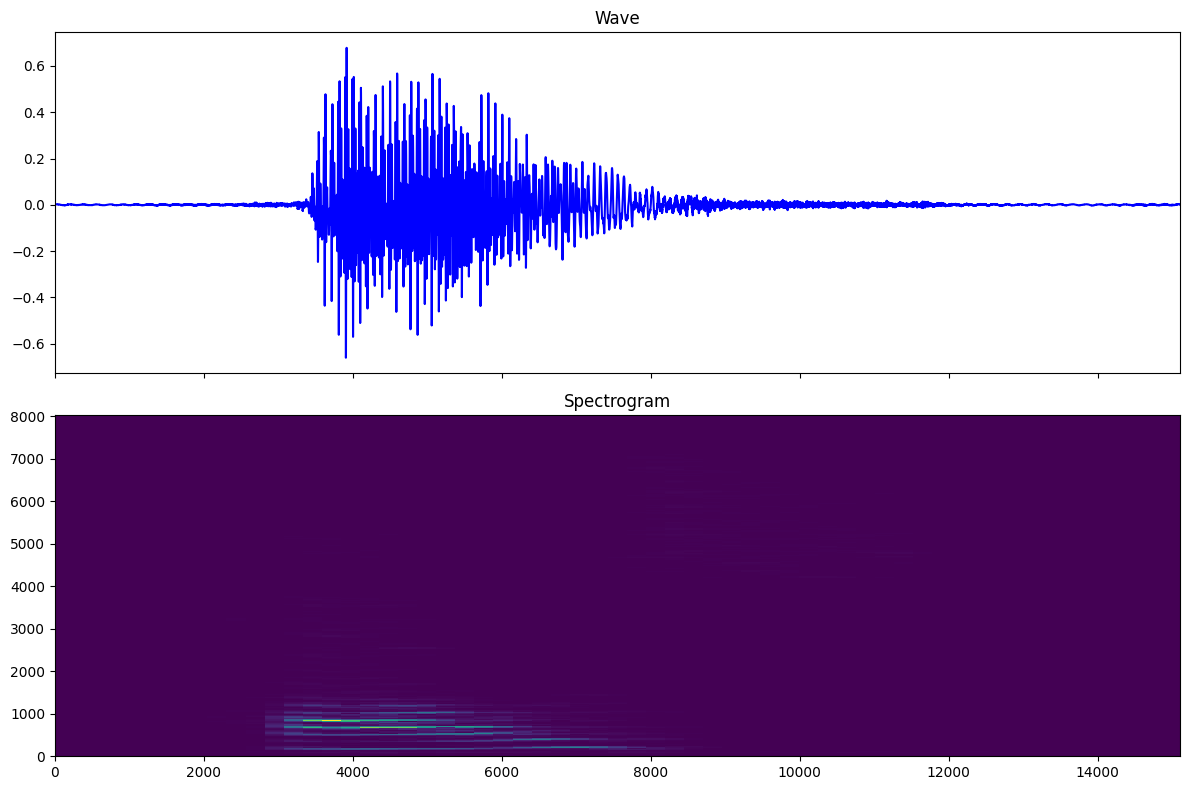

In [40]:
# Let's plot the spectrogram for sample_audio with the following parameters
window_length = 1023
stride_length = 256
fts_length = 1024
# First, generate the spectrogram
sample_spectrogram = get_spectrogram(sample_audio,
                                     window = window_length,
                                     stride = stride_length,
                                     fts = fts_length)
#
f_index_lim, s_index_lim = tf.squeeze(sample_spectrogram,-1).numpy().shape
#
x = np.arange(s_index_lim+1)*stride_length 
# time_diff(x[1], x[0]) = (1/sample_rate) seconds
y = np.arange(f_index_lim+1)*16000/fts_length
# freq_diff(y[1], y[0]) = 1 Hz
#
fig, axis = plt.subplots(2, sharex=True, figsize=(12, 8))
plt.xlim(0,s_index_lim*stride_length)
#
axis[0].plot(tf.squeeze(sample_audio,-1).numpy(), color='b')
axis[0].set_title('Wave')
#
axis[1].pcolormesh(x, y, tf.squeeze(sample_spectrogram,-1).numpy())
axis[1].set_title('Spectrogram')
#
fig.tight_layout()
plt.show()

#### Frequency in mel scale

As you can see from the spectrogram plot, for a speech sample the frequency range is relatively limited. This is a visual demonstration of the effectiveness of the [narrowband](https://en.wikipedia.org/wiki/Voice_frequency) frequency range in telephony.

A better representation would be switch from linear sampling of frequencies to logarithmic sampling or mel scale.

In [41]:
# Here is the standard convention for the mel transformation
def convert_Hz_to_mel(frequency):
    # Converts frequency in Hz to mels 
    # (Ex: 0 Hz = 0 mels, 6300 Hz = 2595 mels.)
    return 2595.0*np.log10(1.0+ frequency/700.0)
#
# And here is the inverse transformation
def convert_mel_to_Hz(mels):
    # Converts from mels to Hz
    return 700*(np.power(10.0, mels/2595.0) - 1.0)
#
# TF.signal has a built-in function for this transformation
def mel_spectrogram(spectrogram, window, stride, fts, sample_rate = 16000,
                    mel_bins = 128, min_f = 50.0, max_f = 7000.0, 
                    channels = True):
    """Logarithmically resamples the frequency axis. The input 'spectrogram'
    is expected to be a tf.tensor with the format (B)FS(C). The arguments
    'window', 'stride', 'fts' are the parameters used to generate 'spectrogram'
    from a waveform, 'sample_rate' is the sample_rate of the waveform.
    'mel_bins' is the length of the output along the mel (frequency) axis.
    ['min_f','max_f'] is the range of frequencies sampled. The default range
    is known as the wideband (50-7000).
    (A shorter range known as the narrowband (300-3400) is also commonly used
    for speech data.)
    'channels=True' indicates that spectrogram has the channel axis.
    """
    # Identify the frequency axis of the input 
    # (1 if input is a batch, 0 otherwise)
    f_axis = spectrogram.shape.rank - 2 - int(channels)
    #
    # Extract the number of sampled frequencies
    # (equals spectrogram.shape[frequency_axis]
    f_bins = fts_length//2 + 1
    #
    # Generate the transformation matrix with wide_
    M = tf.signal.linear_to_mel_weight_matrix(num_mel_bins = mel_bins,
                                              num_spectrogram_bins = f_bins,
                                              sample_rate = sample_rate,
                                              lower_edge_hertz = min_f,
                                              upper_edge_hertz = max_f,
                                              dtype = tf.dtypes.float32,
                                              name=None)
    #
    # Adjust the order of the axes when batch axis is present:
    #  tf.tensordot(M_{ij}, S_{klmn}, (i,l)) = (MS)_{jkmn}
    # transpose to (MS)_{kjmn}.
    if f_axis:
        M = tf.transpose(tf.tensordot(M, spectrogram, [[0], [f_axis]]), [1,0,2,3])
    else:
        M = tf.tensordot(M, spectrogram, [[0], [f_axis]])
    #
    return M

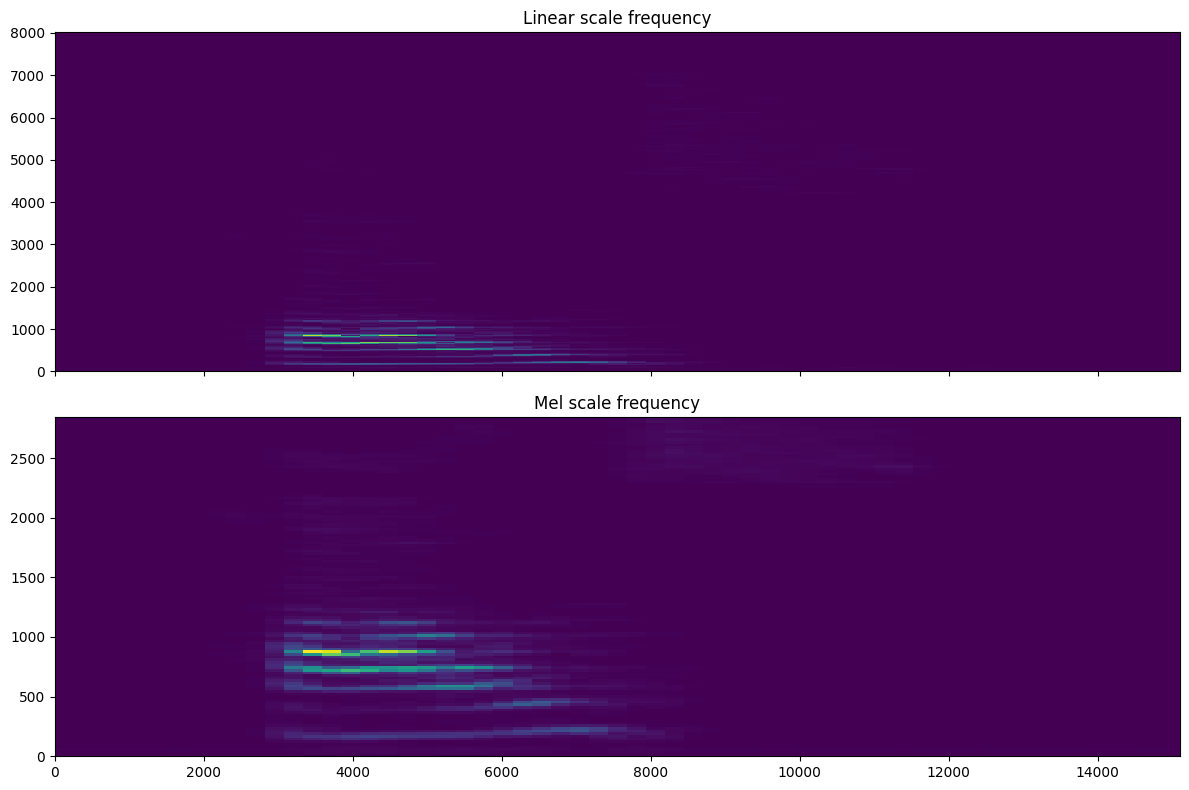

In [42]:
# Let's plot the  two spectrograms for a visual comparison.
window_length = 1023
stride_length = 256
fts_length = 1024
mel_length = 128
#
# First generate the two spectrograms
sample_spectrogram = get_spectrogram(sample_audio,
                                     window = window_length,
                                     stride = stride_length,
                                     fts = fts_length)
#
sample_mel = mel_spectrogram(sample_spectrogram,
                             window = window_length,
                             stride = stride_length,
                             fts = fts_length,
                             mel_bins = mel_length,
                             min_f = 50,
                             max_f = 7000)
# 
f_index_lim, s_index_lim = tf.squeeze(sample_spectrogram,-1).numpy().shape
#
x = np.arange(s_index_lim+1)*stride_length 
# time_diff(x[1], x[0]) = (1/sample_rate) seconds
y = np.arange(f_index_lim+1)*16000/fts_length
# freq_diff(y[1], y[0]) = 1 Hz
y_mel = np.arange(convert_Hz_to_mel(y[0]),
                  convert_Hz_to_mel(y[-1])+0.1,
                  (convert_Hz_to_mel(y[-1])-
                   convert_Hz_to_mel(y[0]))/mel_length)
#
fig, axis = plt.subplots(2, sharex=True, figsize=(12, 8))
plt.xlim(0,s_index_lim*stride_length)
#
axis[0].pcolormesh(x, y, tf.squeeze(sample_spectrogram,-1).numpy())
axis[0].set_title('Linear scale frequency')
#
axis[1].pcolormesh(x, y_mel, tf.squeeze(sample_mel,-1).numpy())
axis[1].set_title('Mel scale frequency')
#
fig.tight_layout()
plt.show()

#### Power in decibel (dB) scale

Lastly we can switch the power or in our case the amplitude to logarithmic scale.

In [43]:
def log_spectrogram(spectrogram, min_amp = 0.0001, ref_amp = 0.1, n = 8.0):
    """Logarithmically scales the amplitudes recorded in 'spectrogram',
    a tf.tensor in the format (B)FS(C). 'min_amp' restricts the minimum
    values of the output to log(min_amp/ref_amp)/n ~ -1.0
    'ref_amp' is a reference value and 'n' is the normalization.
    """
    return tf.divide(tf.math.log(tf.divide(tf.add(spectrogram, min_amp), ref_amp)), n)

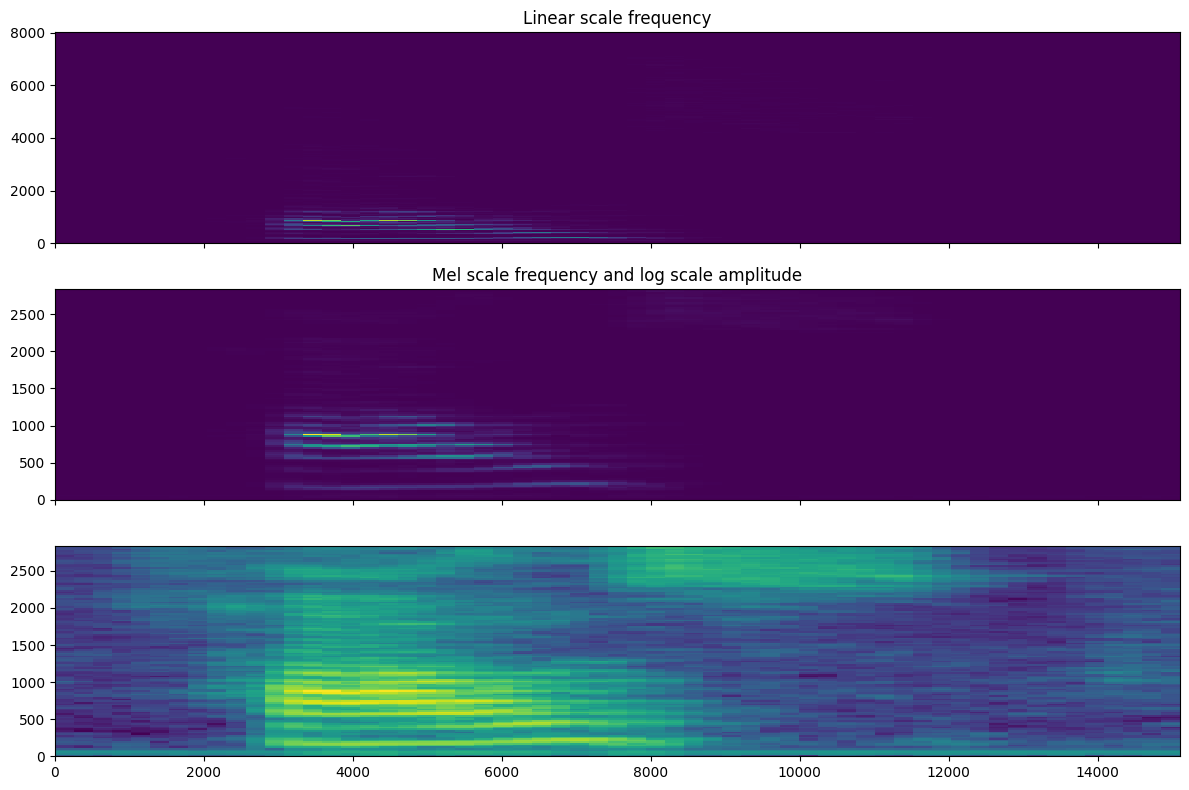

In [44]:
# Let's plot the  two spectrograms for a visual comparison.
window_length = 1023
stride_length = 256
fts_length = 1024
mel_length = 128
#
# First generate the two spectrograms
sample_spectrogram = get_spectrogram(sample_audio,
                                     window = window_length,
                                     stride = stride_length,
                                     fts = fts_length)
#
sample_mel = mel_spectrogram(sample_spectrogram,
                             window = window_length,
                             stride = stride_length,
                             fts = fts_length,
                             mel_bins = mel_length,
                             min_f = 50,
                             max_f = 7000)
#
sample_mel_log = log_spectrogram(sample_mel)
#
f_index_lim, s_index_lim = tf.squeeze(sample_spectrogram,-1).numpy().shape
#
x = np.arange(s_index_lim+1)*stride_length 
# time_diff(x[1], x[0]) = (1/sample_rate) seconds
y = np.arange(f_index_lim+1)*16000/fts_length
# freq_diff(y[1], y[0]) = 1 Hz
y_mel = np.arange(convert_Hz_to_mel(y[0]),
                  convert_Hz_to_mel(y[-1])+0.1,
                  (convert_Hz_to_mel(y[-1])-
                   convert_Hz_to_mel(y[0]))/mel_length)
#
fig, axis = plt.subplots(3, sharex=True, figsize=(12, 8))
plt.xlim(0,s_index_lim*stride_length)
#
axis[0].pcolormesh(x, y, tf.squeeze(sample_spectrogram,-1).numpy())
axis[0].set_title('Linear scale frequency')
#
axis[1].pcolormesh(x, y_mel, tf.squeeze(sample_mel,-1).numpy())
axis[1].set_title('Mel scale frequency')
#
axis[2].pcolormesh(x, y_mel, tf.squeeze(sample_mel_log,-1).numpy())
axis[1].set_title('Mel scale frequency and log scale amplitude')
#
fig.tight_layout()
plt.show()

### Augmentation

We have a few straightforward options to augment our samples:

    - Fade in/out (similar to applying a Hann window)
    - Time masking (simulating a lapse in signal/connection)
    - Frequency masking (for spectrograms)
    - Background noise augmentation

Some of these are implemented in [tfio.audio](https://www.tensorflow.org/io/api_docs/python/tfio/audio) module, along with functions for loading audio waves and converting them to spectrograms with different scalings. We did not use tfio since its support for channels is somewhat patchy. 

Lastly, we can utilize the (limited number of) samples of background noise in the speech commands dataset for augmentation by randomly adding background noise to our samples during training.

In [45]:
# First load the noise samples, split them to 1s samples and concatenate along a new axis.
bg_noise_samples = []
for path in bg_noise_paths:
    x = tf.audio.decode_wav(tf.io.read_file(path))[0]
    x = tf.slice(x, [0,0], [16000*(x.shape[0]//16000),1])
    x = tf.split(x, x.shape[0]//16000, axis=0)
    bg_noise_samples += x
#
bg_noise_samples = tf.convert_to_tensor(bg_noise_samples)
#
print('Number of independent noise samples =', bg_noise_samples.shape[0])

Number of independent noise samples = 398


In [46]:
# Define a function to randomly select floor(rate*batch_size) number of noise samples
# and scatter them along the batch axis of a mostly 0 tensor.
#
def random_noise_sampler(rate, noise_samples, batch_size=128):
    """Generates a tensor of shape(batch_size, noise_samples.shape[1:]) by randomly
    sampling floor(rate*batch_size) number of samples from 'noise_samples' and
    scattering them along the batch axis. The arguments are:
    'rate' is a number between 0 and 1,
    'noise_samples' is a rank 3 tf.tensor with the format (count, length, channels)
    'batch_size' specifies output.shape[0].        
    """
    r = int(rate*batch_size)
    # Generate 'r' number of indicies to select from 'noise_samples'
    p = tf.random.uniform(shape=(r,),
                          minval=0,
                          maxval=noise_samples.shape[0]-1,
                          dtype=tf.int32)
    # Gather 'r' samples, pad to reach shape[0]=batch_size and shuffle along
    # the batch axis before returning.
    return tf.random.shuffle(tf.pad(tf.gather(noise_samples, p),
                                    tf.constant([[0,batch_size-r],[0,0],[0,0]])))

In [47]:
# Create a customized Layer to augment waveforms during training.
#
class Noise_augment(keras.layers.Layer):
    """Adds noise, selected from a provided set of noise samples, to input audio waveform
    during training. Subclass of 'keras.layers.Layer'. Takes the following arguments to
    initialize:
    'rate' is a number between 0 and 1,
    'noise_samples' is a rank 3 tf.tensor with the format (count, length, channels),
    constraint: noise_samples.shape[1,2] = input_shape.
    """
    def __init__(self, rate, noise_samples, **kwargs):
        super().__init__(**kwargs)
        #
        self.rate = rate
        self.noise_samples = noise_samples
        #
    def call(self, inputs, batch_size = 128, training=False):
        # Only add noise during training and if rate>0.
        if training and self.rate > 1/(batch_size+1):
            return tf.add(inputs,
                          random_noise_sampler(rate = self.rate,
                                               noise_samples = self.noise_samples,
                                               batch_size = batch_size)
                         )
        return inputs
    #
    def compute_output_shape(self, input_shape):
        return input_shape

## Prepare data for training

In order to feed our data to a training loop such as 'model.fit', there are two issues we need to address. First, our data labels are a set of strings which cannot be used directly. Thus we will vectorize the labels by assigning an index to each unique label.

The second issue is that our audio dataset is potentially too large to bring to memory and has to be loaded in batches. To resolve this issue, we will utilize a Sequence object to batch-wise preload, feed and off-load the data.

Alternatively we can use the built-in 'keras.utils.audio_ds_from_dir' which serves the same purpose.

### Using keras.utils.Sequence

In [48]:
# Vectorize the labels and create dictionaries to map the vectors
# and labels.
#
labels_dict = {}
labels_reverse_dict = {}
for i, l in zip(np.arange(num_categories),np.unique(train_labels)):
    labels_dict[l] = i
    labels_reverse_dict[i] = l
#
# Convert the train and valid labels using labels_dict using the
# following function:
def vector_labels(labels, dictionary):
    # returns [dictionary[label] for label in labels]
    return np.vectorize(lambda label: dictionary[label])(labels)
#
train_labels = vector_labels(train_labels, labels_dict)
valid_labels = vector_labels(valid_labels, labels_dict)
#
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34])

In [49]:
# Specify the number of categories.
try:
    num_categories
except:
    num_categories = np.unique(train_labels).shape[0]
#
# Customize the sequence class to fetch speech commands samples.
class audio_seq(keras.utils.Sequence):
    # Subclass of keras.utils.Sequence used to generate data from
    # a source (disk).
    def __init__(self, file_paths, labels,
                 num_classes = num_categories,
                 batch_size = 128,
                 sample_shape = (16000,1),
                 shuffle_on_epoch_end = True):
        """Initializes the class.
        'file_paths' points to the source of the data and 
        'labels' are the corresponding labels.
        'num_classes' is the number of distinct classes.
        'batch_size' is the number of samples per batch.
        'sample_shape' is the shape of a single sample.
        'shuffle_on_epoch_end' determines whether the data is 
        shuffled at the end of each epoch.
        """
        #
        super().__init__()
        # Initializes by calling the initializer of the parent class.
        #
        self.paths = file_paths
        self.labels = labels
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.sample_shape = sample_shape
        self.shuffle = shuffle_on_epoch_end
        self.on_epoch_end()
        #
    def __len__(self):
        # Determines the number of batches per epoch.
        return int(self.paths.shape[0] // self.batch_size)
        #
    def __getitem__(self, idx):
        # Loads a batch of data from source.
        #
        batch_paths = self.paths[self.batch_size * idx:
                                 self.batch_size * (idx+1)]
        batch_labels = self.labels[self.batch_size * idx:
                                   self.batch_size * (idx+1)]
        batch_samples = tf.zeros(shape=(0, self.sample_shape[0], self.sample_shape[1]),
                                 dtype=tf.float32)
        for path in batch_paths:
            batch_samples = tf.concat([batch_samples,
                                       tf.expand_dims(load_audio(path),0)],
                                       axis=0)
        #
        return batch_samples, tf.cast(batch_labels, dtype = tf.int32)
        #
    def on_epoch_end(self):
        # Shuffles the entire dataset after each epoch if on_epoch_end=True.
        if self.shuffle:
            self.paths, self.labels = shuffle(self.paths, self.labels)

In [50]:
# Generate the train and validation datasets as Sequence objects.
train_seq = audio_seq(train_paths, train_labels)
valid_seq = audio_seq(valid_paths, valid_labels)

In [51]:
# Here is a what train_seq returns when called in a training loop:
for samples, labels in train_seq:
    print('A batch of samples with shape = {}'.format(samples.shape))
    print('And the corresponding labels with shape = {}'.format(labels.shape))
    break

A batch of samples with shape = (128, 16000, 1)
And the corresponding labels with shape = (128,)


### Using keras.utils.audio_dataset_from_directory

To fix: Broadcast issue when Noise_augment layer is present.

In [34]:
# A more straight forward way to load our dataset is through
# 'keras.utils.audio_dataset_from_directory'.
# However, it offers less control over the process
#
# Import dependencies
import tensorflow_io as tfio
#
def gen_audio_ds_from_dir(train_ds_dir):
    """Generates a 'tf.data.dataset' object from the directory
    'train_ds_dir' with integer labels associated to the index
    of the list 'audio_ds.class_names'."""
    audio_ds = tf.keras.utils.audio_dataset_from_directory(
        directory = train_ds_dir,
        labels = "inferred",
        label_mode = "int",
        class_names = None,
        batch_size = 128,
        sampling_rate = 16000,
        output_sequence_length = 16000,
        ragged = False,
        shuffle = True,
        seed = 248,
        validation_split = 0.15,
        subset = "both",
        follow_links = False
    )
    return audio_ds

In [35]:
# To exclude the bg noise samples we need to move it away.
!mv {home_dir+'/datasets/speech_commands_train/_background_noise_'} {home_dir+'/datasets/'}

In [39]:
# Generate training and validation datasets
#
train_ds, valid_ds = gen_audio_ds_from_dir(train_ds_dir)
#
# Print the identified classes
print("Class names:", np.array(train_ds.class_names))

Found 105829 files belonging to 35 classes.
Using 89955 files for training.
Using 15874 files for validation.
Class names: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']


## Baseline models

Before we modify a relatively large (YAMNet has over 3.7e6 trainable parameters) pretrained model to transfer to the speech commands dataset, let us build and train a few smaller models (~4e4 trainable parameters) to set a performance baseline.

In [52]:
# Create a dictionary to record traning history of our models.
histories = {}

### Waveform baseline model

In [53]:
# Specify the number of categories.
try:
    num_categories
except:
    num_categories = np.unique(train_labels).shape[0]
#
# Define a function that generates a simple 1D CNN model
# for speech commands in wave format.
def gen_baseline_wave_model(input_shape = (16000,1),
                            noise_augment_rate = 0.0,
                            noise_samples = bg_noise_samples,
                            model_name = None):
    # Generates a simple Conv1D model for the speech commands dataset.
    # The default input is a rank 2 (+1 for the batch axis) wave tensor.
    #
    inputs = layers.Input(shape=input_shape)
    # Include noise augmentation layer
    x = Noise_augment(rate = noise_augment_rate,
                      noise_samples = noise_samples)(inputs)
    # Downsample the input waveform
    x = layers.AveragePooling1D(2)(x)
    x = layers.Conv1D(32, 16, 8, activation='relu')(x)
    x = layers.MaxPooling1D(4)(x)
    x = layers.Conv1D(64, 4, 2, activation='relu')(x)
    x = layers.AveragePooling1D(8)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_categories, activation='softmax')(x)
    #
    return keras.Model(inputs, x, name = model_name)

In [54]:
# Choose the optimizer, loss function and metrics with which to compile the model.
# We will choose 'sparse_categoriacal_crossentropy' as the loss function since the 
# labels are valued in range(num_categories) while the model outputs are one-hot encoded.
optim0 = "adam"
loss0 = "sparse_categorical_crossentropy"
metrics0 = ["accuracy"]
callb0 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        patience=3,
                                        restore_best_weights=True)]
#
# Instantiate, build and compile the baseline model
speech_commands_model_0 = gen_baseline_wave_model(model_name='baseline_0')
speech_commands_model_0.build(input_shape=(16000,1))
speech_commands_model_0.compile(optimizer="adam",
                                loss="sparse_categorical_crossentropy",
                                metrics=['accuracy'])
#
# Print model summary
speech_commands_model_0.summary()

Model: "baseline_0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16000, 1)]        0         
                                                                 
 noise_augment (Noise_augme  (None, 16000, 1)          0         
 nt)                                                             
                                                                 
 average_pooling1d (Average  (None, 8000, 1)           0         
 Pooling1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 999, 32)           544       
                                                                 
 max_pooling1d (MaxPooling1  (None, 249, 32)           0         
 D)                                                              
                                                        

In [ ]:
# Train the baseline model
#
history = speech_commands_model_0.fit(train_seq,
                                      validation_data = valid_seq,
                                      batch_size = 128,
                                      epochs = 30,
                                      callbacks = callb0,
                                      verbose = 1)

In [ ]:
# Record training history in histories.
#
histories['waveform_baseline_0'] = history

In [55]:
# Save model wieghts
#speech_commands_model_0.save_weights(
#    home_dir+'/models/05_speech_commands/waveform_baseline_0.h5')
#
# Load node model weights (the provided weights are the result of ~30 
# epochs of training)
speech_commands_model_0.load_weights(
    home_dir+'/models/05_speech_commands/waveform_baseline_0.h5')

In [56]:
# Evaluate model performance on the validation dataset
speech_commands_model_0.evaluate(valid_seq)

124/124 [==============================] - 17s 139ms/step - loss: 1.0472 - accuracy: 0.7318


[1.0471506118774414, 0.7317918539047241]

### Waveform baseline model with noise augmentation

In [57]:
# Generate a new model with noise augmentation
speech_commands_model_0_wn = gen_baseline_wave_model(noise_augment_rate=0.2,
                                                     model_name='baseline_0_wn')
speech_commands_model_0_wn.build(input_shape=(16000,1))
speech_commands_model_0_wn.compile(optimizer="adam",
                                   loss="sparse_categorical_crossentropy",
                                   metrics=['accuracy'])
#
# Print model summary
#speech_commands_model_0_wn.summary()

In [ ]:
# Train the new baseline model
#
history = speech_commands_model_0_wn.fit(train_seq,
                                         validation_data = valid_seq,
                                         batch_size = 128,
                                         epochs = 30,
                                         callbacks = callb0,
                                         verbose = 1)

In [ ]:
# Record training history in 'histories'.
histories['waveform_baseline_0_wn'] = history

In [60]:
# Save model wieghts
#speech_commands_model_0_wn.save_weights(
#    home_dir+'/models/05_speech_commands/waveform_baseline_0_wn.h5')
#
# Load node model weights
speech_commands_model_0_wn.load_weights(
    home_dir+'/models/05_speech_commands/waveform_baseline_0_wn.h5')

In [61]:
# Evaluate model performance on the validation dataset
speech_commands_model_0_wn.evaluate(valid_seq)

124/124 [==============================] - 15s 119ms/step - loss: 0.8912 - accuracy: 0.7746


[0.8911558985710144, 0.774634599685669]

### Spectrogram baseline model

In [62]:
# Specify the number of categories.
try:
    num_categories
except:
    num_categories = np.unique(train_labels).shape[0]
#
# Defome a function to convert waveforms into log-amp scale, mel-scale
# spectrograms with fixed parameters.
def waveform_to_spectrogram(samples):
    # Converts a batch of waveform audio samples to spectrograms with
    # logarithmic amplitude scaling and mel scaling for frequencies.
    #
    samples = get_spectrogram(samples, window=1023, stride=256, fts=1024)
    samples = mel_spectrogram(samples, window=1023, stride=256, fts=1024,
                              mel_bins=128, min_f=50, max_f=3000)
    return log_spectrogram(samples)
#
# Define a function that generates a simple 2D CNN model
# for speech commands in spectrogram form.
def gen_baseline_spectrogram_model(input_shape = (16000,1),
                                   noise_augment_rate = 0.0,
                                   noise_samples = bg_noise_samples,
                                   model_name = None):
    # Generates a simple Conv2D model for the speech commands dataset.
    # The default input is a rank 2 (+1 for the batch axis) wave tensor
    # which we convert to spectrogram using a lambda layer.
    #
    inputs = layers.Input(shape=input_shape)
    x = Noise_augment(rate = noise_augment_rate,
                      noise_samples = noise_samples)(inputs)
    x = layers.Lambda(waveform_to_spectrogram,
                      output_shape = (128,59,1))(x)
    x = layers.Conv2D(8, 8, 2, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(16, 4, 2, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_categories, activation='softmax')(x)
    #
    return keras.Model(inputs, x, name = model_name)

In [63]:
# We shall use the same functions to compile the model as the
# waveform baseline model.
#optim0 = "adam"
#loss0 = "sparse_categorical_crossentropy"
#metrics0 = ["accuracy"]
#callb0 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                                        patience=3,
#                                        restore_best_weights=True)]
#
# Instantiate, build and compile the baseline model
speech_commands_model_1 = gen_baseline_spectrogram_model(noise_augment_rate=0.15,
                                                         model_name='baseline_1')
speech_commands_model_1.build(input_shape=(1,16000,))
speech_commands_model_1.compile(optimizer="adam",
                                loss="sparse_categorical_crossentropy",
                                metrics=['accuracy'])
#
# Print model summary
speech_commands_model_1.summary()

Model: "baseline_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16000, 1)]        0         
                                                                 
 noise_augment_2 (Noise_aug  (None, 16000, 1)          0         
 ment)                                                           
                                                                 
 lambda (Lambda)             (None, 128, 59, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 61, 26, 8)         520       
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 13, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 5, 16)         2

In [ ]:
# Train the baseline model
#
history = speech_commands_model_1.fit(train_seq,
                                      validation_data = valid_seq,
                                      batch_size = 128,
                                      epochs = 10,
                                      callbacks = callb0,
                                      verbose = 1)

In [ ]:
# Record training history in 'histories'.
histories['sg_baseline_0'] = history

In [66]:
# Save model wieghts
#speech_commands_model_1.save_weights(
#    home_dir+'/models/05_speech_commands/spectrogram_baseline_0.h5')
#
# Load node model weights (the provided weights are the result of ~10
# epochs of training.)
speech_commands_model_1.load_weights(
    home_dir+'/models/05_speech_commands/spectrogram_baseline_0.h5')

In [67]:
# Evaluate model performance on the validation dataset
speech_commands_model_1.evaluate(valid_seq)

124/124 [==============================] - 17s 129ms/step - loss: 0.5602 - accuracy: 0.8363


[0.5601716637611389, 0.8362525105476379]

## Transfer learning using the pretrained YAMNet model

Now that we have a set the performance baseline (~83% validation accuracy), we are ready to utilize transfer learning and take full advantage of the time and resources used to train YAMNet.

### YAMNet model setup

In [ ]:
# Import YAMNet model from the git repository
if not os.path.exists(home_dir+'tmp'):
    os.mkdir('tmp')
#
# Check if the repository is present or clashes with current folders.
if os.path.exists(home_dir+'/tmp/models'):
    raise ValueError("~/tmp/models already exists!")
#
# clone git repository in the tmp folder
%cd tmp
!git clone https://github.com/tensorflow/models.git

In [ ]:
%cd {home_dir+'/tmp/models/research/audioset/yamnet'}
#
# Import yamnet python files
import params as yamnet_params
import yamnet as yamnet_model

In [ ]:
# Check if the saved model weights file has been download previously.
if os.path.exists('yamnet.h5'):
    raise ValueError("File exists already!")
#
# Download the pretrained model:
tf.keras.utils.get_file('yamnet.h5',
                        'https://storage.googleapis.com/audioset/yamnet.h5',
                        cache_subdir=os.getcwd())

In [71]:
# Pretrained YAMNet model setup:
#
# List of class names for the original pretrained model
yamnet_class_names = yamnet_model.class_names('yamnet_class_map.csv')
#
# Specify model parameters:
#  'sample_rate': Expected sample rate of input waveforms.
#  'patch_hop_seconds': Duration between patches.
#  'patch_window_seconds': Duration of each patch.
# Note: yamnet accepts inputs of variable length and breaks
# them into (overlapping) patches of fixed length.
params = yamnet_params.Params(sample_rate=16000,
                              patch_hop_seconds = 1.0,
                              patch_window_seconds = 1.0)
#
# Import model architecture:
yamnet = yamnet_model.yamnet_frames_model(params)
#
# Import model weights:
yamnet.load_weights('yamnet.h5')

In [72]:
# Print the current model parameters.
for p in dir(params):
    if p[0] != '_':
        print(p+" = ", eval('params.'+p))

batchnorm_center =  True
batchnorm_epsilon =  0.0001
batchnorm_scale =  False
classifier_activation =  sigmoid
conv_padding =  same
log_offset =  0.001
mel_bands =  64
mel_max_hz =  7500.0
mel_min_hz =  125.0
num_classes =  521
patch_bands =  64
patch_frames =  100
patch_hop_seconds =  1.0
patch_window_seconds =  1.0
sample_rate =  16000
stft_hop_seconds =  0.01
stft_window_seconds =  0.025
tflite_compatible =  False


In [73]:
# Sample output
# Note: yamnet expects inputs without the channels axis.
sample_output = yamnet(tf.squeeze(sample_audio,-1))
#
print('Model predictions shape: ', sample_output[0].shape)
print('Patch shape: ', sample_output[1].shape)
print('Spectrogram shape: ', sample_output[2].shape)

Model predictions shape:  (1, 521)
Patch shape:  (1, 1024)
Spectrogram shape:  (100, 64)


In [ ]:
# You can print out the model summary to get an idea of the scale
# of the model and its architecture.
yamnet.summary()

In [75]:
# Here is a reduced summary of the model:
print('Input shape =', yamnet.input_shape)
print('Output shape =', yamnet.output_shape)
print('Number of layers =', len(yamnet.layers))
print('Number of trainable parameters =',
      np.sum([keras.backend.count_params(p) for p in yamnet.trainable_variables]))

Input shape = (None,)
Output shape = [(None, 521), (None, 1024), (None, 64)]
Number of layers = 106
Number of trainable parameters = 3729481


### Transfer learning with minimal training

Broadly speaking, the task of the initial layers of a DNN is to recognize 'surface-level' features while, as we delve deeper, the learned features become more and more abstract. The deeper the layer, the more abstract the features, and more domain specific!

Thus, when transfering a pretrained model from one domain to another, we need to figure out at what 'depth' the features of the two domains start diverging. That is to say, we need to decide the extend to which we retrain the model in the new domain.

The two extremes are the most straightforward: At one extreme, and the least resource-hungry option, is to only re-calibrate the model. This boils down to replacing the last trainable layer of the pretrained model and only training this layer with the rest of the model parameters completely frozen.

The opposite extreme is to retrain the entire model.

Lets try the simplest case of replacing and training only the last trainable layer.

In [77]:
# yamnet.layers[-2] is the last trainable layer of yamnet.
# To replace it, we need to know its input_shape:
print('Input of the last trainable layer has shape =',
      yamnet.layers[-2].input_shape)

Input of the last trainable layer has shape = (None, 1024)


In [78]:
# Recall that speech commands has 35 distinct commands:
print('Number of distinct classes =', num_categories)

Number of distinct classes = 35


In [79]:
# Define a function to flatten the input batch into a
# 1D tensor. (Recall that yamnet takes as input a 1D
# tensor which it segments to a batch of 1D tensors.)
#
def yamnet_input_reshape_model(r = 0.2,
                               noise = bg_noise_samples):
    """Generates a model that first applies noise augmentation
    by randomly adding noise from a specified source to the inputs.
    The model then flattens the resulting input with
        input_shape = (batch_size,16000,1) 
    along the batch axis:
        output_shape = (batch_size*16000,)
    'r' specifies the ratio of augmented samples per batch.
    'noise' points to a set of preloaded noise samples.
    """        
    inputs = layers.Input(shape=(16000,1))
    # Add noise augmentation layer here.
    output = Noise_augment(rate = r,
                           noise_samples = noise)(inputs)
    output = tf.reshape(output, (-1,))
    return keras.Model(inputs, output)
#
# Define a function to generate a model by shaving off
# the last few layers of yamnet.
#
def truncated_yamnet_model(yn_model = yamnet, t_len = 104):
    """Generates a truncated version of a pretrained yamnet model 
    with the last (106-truncated_len) layers removed.
    'yn_model' points to a preloaded yamnet model.
    't_len' specifies the number of layers after truncation.
    (t_len < 106 = len(yamnet.layers) )
    """
    inputs = yn_model.input
    output = yn_model.layers[t_len - 1].output
    return keras.Model(inputs, output)
#
# Define a function to generate the new set of last layers to
# attach to the truncated yamnet model.
#
def speech_commands_classifier(inputs, num_classes = num_categories):
    """Generates a classification module for the speech commands dataset
    which can be attached to a truncated pretrained model.
    'inputs' is expected to have shape = (batch_size, None)
    'num_classes' determines output_shape = (batch_size, num_classes)
    """
    x = layers.Dense(num_classes)(inputs)
    x = layers.Softmax(axis=-1)(x)
    #
    return x
#
# Define a function to generate our new model by attaching 
# the 'reshape_model' to the surface, and the new classifier
# to the depth of truncated yamnet model.
#
def transferred_yamnet_model(num_classes = num_categories,
                             rate = 0.2,
                             noise_samples = bg_noise_samples,
                             yamnet_model = yamnet,
                             truncated_len = 104,
                             model_name = None):
    """Generates a model that sequentially connects 3 modules:
    module_1: Input-Augment-Reshape model ('yamnet_input_reshape_model')
    module_2: Truncated YAMNet model ('truncated_yamnet_model')
    module_3: New domain classifier layers ('speech_commands_classifier').
    """
    inputs = layers.Input(shape=(16000,1))
    #
    x = yamnet_input_reshape_model(r = rate,
                                   noise = noise_samples)(inputs)
    x = truncated_yamnet_model(yn_model = yamnet_model,
                               t_len = truncated_len)(x)
    #    
    x = speech_commands_classifier(inputs = x, num_classes = num_classes)
    #
    return keras.Model(inputs, x, name = model_name)

In [80]:
# Specify the optimizer, loss, metrics and callbacks to use for training.
optim0 = "adam"
loss0 = "sparse_categorical_crossentropy"
metrics0 = ["accuracy"]
callb0 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        patience=5,
                                        restore_best_weights=True)]
#
# Instantiate, compile and build the new model
transferred_yamnet_0 = transferred_yamnet_model(num_classes = num_categories,
                                                rate = 0.2,
                                                noise_samples = bg_noise_samples,
                                                yamnet_model = yamnet,
                                                truncated_len = 104,
                                                model_name='yamnet_0')
#
transferred_yamnet_0.build(input_shape=(16000,1))
#
transferred_yamnet_0.compile(optimizer="adam",
                             loss="sparse_categorical_crossentropy",
                             metrics=['accuracy'])
#
# You can also build the model with a simple call.
#transferred_yamnet_0(tf.squeeze(sample_audio));
#
# Freeze all pre-trained layers
frozen_layers = []
for i in range(len(yamnet.layers)):
    if yamnet.layers[i].trainable:
        frozen_layers.append(i)
        yamnet.layers[i].trainable = False
#
# Print the number of trainable parameters of the model.
print('Number of trainable parameters =',
      np.sum([keras.backend.count_params(p) for p in transferred_yamnet_0.trainable_variables]))

Number of trainable parameters = 35875


In [ ]:
# Train the new model
#
history = transferred_yamnet_0.fit(train_seq,
                                   validation_data=valid_seq,
                                   batch_size = 128,
                                   epochs = 15,
                                   callbacks = callb0,
                                   verbose = 1)

In [ ]:
# Record training history in 'histories'.
histories['yamnet-2_0'] = history

In [83]:
# Save model wieghts
#transferred_yamnet_0.save_weights(
#    home_dir+'/models/05_speech_commands/transferred_yamnet_0.h5')
#
# Load node model weights (the provided weights are the result of ~15 
# epochs of training)
transferred_yamnet_0.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_0.h5')

In [84]:
# Evaluate model performance on the validation dataset
transferred_yamnet_0.evaluate(valid_seq)

124/124 [==============================] - 28s 221ms/step - loss: 0.0991 - accuracy: 0.9704


[0.09912629425525665, 0.9703881144523621]

### Full model training

With minimal training, the pretrained yamnet model with only the two final layers replaced, vastly outperforms our baseline models and breaks the 97% validation accuracy mark. We can still gain a slight edge by adjusting all the weights in the model with a few epochs of training the unrestricted model.

In [85]:
# Unfreeze the frozen trainable layers.
for i in frozen_layers:
    yamnet.layers[i].trainable = True
#
# Print the number of trainable parameters of the model.
print('Number of trainable parameters =',
      np.sum([keras.backend.count_params(p) for p in transferred_yamnet_0.trainable_variables]))

Number of trainable parameters = 3231331


In [ ]:
# Train the unfrozen model for a few more epochs.
#
history = transferred_yamnet_0.fit(train_seq,
                                   validation_data=valid_seq,
                                   batch_size = 128,
                                   epochs = 1,
                                   callbacks = callb0,
                                   verbose = 1)

In [ ]:
histories['yamnet-2_1'] = history

In [88]:
# Save model wieghts
#transferred_yamnet_0.save_weights(
#    home_dir+'/models/05_speech_commands/transferred_yamnet_1.h5')
#
# Load node model weights
transferred_yamnet_0.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_1.h5')

In [89]:
# Evaluate model performance on the validation dataset
transferred_yamnet_0.evaluate(valid_seq)

124/124 [==============================] - 45s 365ms/step - loss: 0.0638 - accuracy: 0.9803


[0.06383508443832397, 0.9802797436714172]

### Middle-ground

As you can see, retraining the full model does offer a marginal improvement in performance. However, this does not necessarily make retraining the full model the best choice. Just as the trained parameters of the deeper layers are more domain specific, so are the hyperparameters, i.e. the model architecture. 

In [67]:
# Reload yamnet weights and freeze pretrained layers.
yamnet.load_weights('yamnet.h5')
#
frozen_layers = []
for i in range(len(yamnet.layers)):
    if yamnet.layers[i].trainable:
        frozen_layers.append(i)
        yamnet.layers[i].trainable = False

In [68]:
print('layer[66] (relu activation):\n', yamnet.layers[66].get_config())
print('layer[66] output_shape =', yamnet.layers[66].output_shape)

layer[66] (relu activation):
 {'name': 'layer8/pointwise_conv/relu', 'trainable': False, 'dtype': 'float32', 'max_value': None, 'negative_slope': array(0., dtype=float32), 'threshold': array(0., dtype=float32)}
layer[66] output_shape = (None, 7, 4, 512)


In [69]:
# We need a new classifier module to attach to the yamnet model
# truncated at layer[57].
L66_output_shape = tuple([yamnet.layers[66].output_shape[i] for i in [1,2,3]])
#
def spch_cmmnds_classifier_66(inputs,
                              input_shape = L66_output_shape,
                              num_classes = num_categories):
    """Generates a classification module for the speech commands dataset
    which can be attached to a truncated pretrained model. Assumes yamnet
    has been truncated at the 58th layer (layer[57]).
    'inputs' is expected output of the truncated yamnet
    'input_shape' is expected to match yamnet.layers[57].output_shape[1:]
    'num_classes' determines output_shape = (batch_size, num_classes)
    """
    x = layers.Conv2D(512, 2, 1, padding='same')(inputs)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(512, 2, 1, padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes)(x)
    x = layers.Softmax(axis=-1)(x)
    #
    return x
#
# We also need a new function to glue our modules together.
def transferred_yamn66_model(num_classes = num_categories,
                             rate = 0.2,
                             noise_samples = bg_noise_samples,
                             yamnet_model = yamnet,
                             truncated_len = 67,
                             model_name = None):
    """Generates a model that sequentially connects 3 modules:
    module_1: Input-Augment-Reshape model ('yamnet_input_reshape_model')
    module_2: Truncated YAMNet model ('truncated_yamnet_model')
    module_3: New domain classifier layers ('sc_classifier_66').
    """
    inputs = layers.Input(shape=(16000,1))
    #
    x = yamnet_input_reshape_model(r = rate,
                                   noise = noise_samples)(inputs)
    x = truncated_yamnet_model(yn_model = yamnet_model,
                               t_len = truncated_len)(x)
    #    
    x = spch_cmmnds_classifier_66(inputs = x,
                                  input_shape = L66_output_shape,
                                  num_classes = num_classes)
    #
    return keras.Model(inputs, x, name = model_name)

In [70]:
# Specify the optimizer, loss, metrics and callbacks to use for training.
optim0 = "adam"
loss0 = "sparse_categorical_crossentropy"
metrics0 = ["accuracy"]
callb0 = [keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                        patience=5,
                                        restore_best_weights=True)]
#
# Instantiate, compile and build the new model
transferred_yamnet_66 = transferred_yamn66_model(num_classes = num_categories,
                                                 rate = 0.2,
                                                 noise_samples = bg_noise_samples,
                                                 yamnet_model = yamnet,
                                                 truncated_len = 67,
                                                 model_name='yamnet_66')
#
transferred_yamnet_66.build(input_shape=(16000,))
#
transferred_yamnet_66.compile(optimizer="adam",
                              loss="sparse_categorical_crossentropy",
                              metrics=['accuracy'])
#
# You can also build the model with a simple call.
#transferred_yamnet_0(tf.squeeze(sample_audio));
#
# Print the number of trainable parameters of the model.
print('Number of trainable parameters =',
      np.sum([keras.backend.count_params(p) for p in transferred_yamnet_66.trainable_variables]))

Number of trainable parameters = 2116131


In [ ]:
# Train the unfrozen model for a few more epochs.
#
history = transferred_yamnet_66.fit(train_seq,
                                    validation_data=valid_seq,
                                    batch_size = 128,
                                    epochs = 10,
                                    callbacks = callb0,
                                    verbose = 1)

In [ ]:
histories['yamnet_66'] = history

In [71]:
# Save model wieghts
#transferred_yamnet_66.save_weights(
#    home_dir+'/models/05_speech_commands/transferred_yamnet_66.h5')
#
# Load node model weights (the provided weights are the result of ~25 
# epochs of training)
transferred_yamnet_66.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_66.h5')

In [72]:
# Evaluate model performance on the validation dataset
transferred_yamnet_66.evaluate(valid_seq)

124/124 [==============================] - 26s 208ms/step - loss: 0.0998 - accuracy: 0.9795


[0.09984921663999557, 0.9794606566429138]

# Performance

## Import test dataset

In [173]:
# Test dataset directory
test_ds_dir = home_dir+'/datasets/speech_commands_test/'
#
# Create and populate a list of file paths for the test dataset.
test_paths = []
for folder, labels, samples in os.walk(test_ds_dir):
    for sample in samples:
        if sample[-3:] == 'wav':
            test_paths.append([folder+'/'+sample, folder[len(test_ds_dir):]])
#
# Convert the list to pandas.Dataframe
test_paths = pd.DataFrame(test_paths, columns=['file_path', 'category'])
#
# Number of samples per category
#data_paths.groupby('category').count()
#
# List the unique categories
test_paths['category'].unique()

array(['yes', 'down', 'right', 'no', 'off', '_silence_', 'up', 'left',
       'on', 'stop', 'go', '_unknown_'], dtype=object)

In [174]:
# Separate '_silence_' and '_unknown_' categories
silence_paths = test_paths.where(
    test_paths['category']=='_silence_').dropna()
unknown_paths = test_paths.where(
    test_paths['category']=='_unknown_').dropna()
#
test_paths = test_paths.where(
    test_paths['category']!='_silence_').dropna()
test_paths = test_paths.where(
    test_paths['category']!='_unknown_').dropna()

In [175]:
# Shuffle and reset the index of the dataframes
test_paths = test_paths.sample(frac = 1)
test_paths.reset_index(inplace=True)
#
# Remaining number of categories
num_test_categories = test_paths['category'].unique().shape[0]
print('Number of distinct commands = {}'.format(num_test_categories))

Number of distinct commands = 10


In [176]:
# Create separate numpy arrays for sample paths and labels.
# Vectorize the labels using the previously define labels_dict.
#
test_labels = np.vectorize(labels_dict.get)(np.array(test_paths['category']))
test_paths = np.array(test_paths['file_path'])

In [177]:
# Create test Sequence
#
test_seq = audio_seq(test_paths, test_labels)

## Evaluate model performance

In [87]:
# Create a dictionary to record model performances
test_performance = {}

In [88]:
# Baseline with waveform inputs and without augmentation
#
speech_commands_model_0.load_weights(
    home_dir+'/models/05_speech_commands/waveform_baseline_0.h5')
#
test_performance['wf_baseline_0'] = speech_commands_model_0.evaluate(test_seq)

31/31 [==============================] - 4s 130ms/step - loss: 1.1159 - accuracy: 0.7069


In [89]:
# Baseline with waveform inputs and with noise augmentation
#
speech_commands_model_0_wn.load_weights(
    home_dir+'/models/05_speech_commands/waveform_baseline_0_wn.h5')
#
test_performance['wf_baseline_0_wn'] = speech_commands_model_0_wn.evaluate(test_seq)

31/31 [==============================] - 4s 115ms/step - loss: 0.8923 - accuracy: 0.7704


In [90]:
# Baseline with waveform inputs and without augmentation
#
speech_commands_model_1.load_weights(
    home_dir+'/models/05_speech_commands/spectrogram_baseline_0.h5')
#
test_performance['sg_baseline_0'] = speech_commands_model_1.evaluate(test_seq)

31/31 [==============================] - 4s 129ms/step - loss: 0.5712 - accuracy: 0.8266


In [91]:
# YAMNet[:-2] with minimal training 
#
transferred_yamnet_0.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_0.h5')
#
test_performance['yamnet-2_0'] = transferred_yamnet_0.evaluate(test_seq)

31/31 [==============================] - 6s 188ms/step - loss: 0.0632 - accuracy: 0.9793


In [103]:
# YAMNet[:-2] with full training (Reload model before running)
#
transferred_yamnet_0.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_1.h5')
#
test_performance['yamnet-2_1'] = transferred_yamnet_0.evaluate(test_seq)

31/31 [==============================] - 7s 197ms/step - loss: 0.0418 - accuracy: 0.9869


In [104]:
# YAMNet[:67] with minimal training
#
transferred_yamnet_66.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_66.h5')
#
test_performance['yamnet_66'] = transferred_yamnet_66.evaluate(test_seq)

31/31 [==============================] - 6s 176ms/step - loss: 0.0646 - accuracy: 0.9831


In [105]:
test_performance

{'wf_baseline_0': [1.1158993244171143, 0.7069052457809448],
 'wf_baseline_0_wn': [0.892331063747406, 0.7704132795333862],
 'sg_baseline_0': [0.5711669325828552, 0.8266128897666931],
 'yamnet-2_0': [0.0631522387266159, 0.9793346524238586],
 'yamnet-2_1': [0.0417979396879673, 0.9868951439857483],
 'yamnet_66': [0.06457618623971939, 0.9831148982048035]}

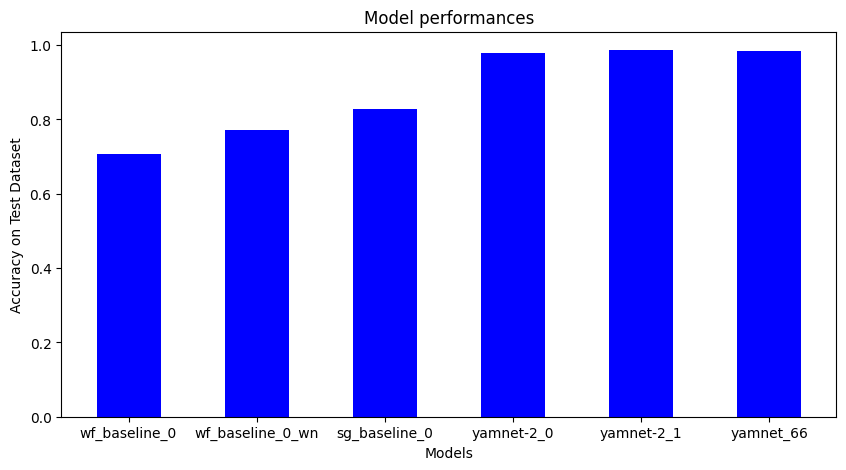

In [106]:
accuracies = {key:test_performance[key][1] for key in test_performance}
models = list(accuracies.keys())
acu_cs = list(accuracies.values())

fig = plt.figure(figsize = (10, 5))

# Plot as a bar plot.
plt.bar(models, acu_cs, color = 'b', width = 0.5)

plt.xlabel("Models")
plt.ylabel("Accuracy on Test Dataset")
plt.title("Model performances")
plt.show()

## Inference

Lastly, we can use any of our models to infer the labels of the unknown samples provided in the speech commands test dataset.

In [178]:
# Unknown sample paths
unknown_paths = np.array(unknown_paths['file_path'])
unknown_paths.shape

(408,)

In [182]:
# Load unknown samples
unknown_samples = np.zeros((unknown_paths.shape[0], 16000, 1), dtype='float32')
for i in np.arange(np.shape(unknown_paths)[0]):
    unknown_samples[i] += load_audio(unknown_paths[i])

In [229]:
# Create a dictionary {model : model.predict(unknown)}
unknown_predictions = {}

In [230]:
# Run inference and convert to the original labels
#
unknown_predictions['sg_baseline_0'] = speech_commands_model_1.predict(unknown_samples)

13/13 [==============================] - 0s 12ms/step


In [231]:
transferred_yamnet_0.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_1.h5')
unknown_predictions['yamnet-2_1'] = transferred_yamnet_0.predict(unknown_samples)

13/13 [==============================] - 0s 30ms/step


In [232]:
transferred_yamnet_66.load_weights(
    home_dir+'/models/05_speech_commands/transferred_yamnet_66.h5')
unknown_predictions['yamnet_66'] = transferred_yamnet_66.predict(unknown_samples)

13/13 [==============================] - 0s 28ms/step


In [266]:
# We can also look at the average of the different model predictions,
# a practice known as ensembling.
unknown_predictions['ensemble'] = np.average(list(unknown_predictions.values()), axis=0)

In [267]:
# Check samples for which the predictions do not match
unknown_labels = {}
for model in unknown_predictions:
    unknown_labels[model] = np.argmax(unknown_predictions[model],axis=1)
#
# Define a function to pair all included models
def distinct_pairs(x: list):
    pairs = []
    while x:
        y = x.pop()
        pairs += [(y,z) for z in x]
    return pairs
#
# Create an array to store the results
disputed_labels = np.zeros(unknown_paths.shape[0])
#
# Compare predictions for all distinct pairs of models
for x, y in distinct_pairs(list(unknown_labels.keys())):
    disputed_labels += np.abs(unknown_labels[x] - unknown_labels[y])
#
# Store the indices of samples for which the prediction of any pair
# of models do not match.
disputed_labels = np.flatnonzero(disputed_labels)
#
print('Indices of disputed labels =', disputed_labels)

Indices of disputed labels = [  0   2  14  22  26  28  36  39  49  52  67  69  74  79  82  85  92  95
  98 102 119 129 131 133 142 146 152 155 163 164 166 174 180 184 194 196
 221 224 225 235 245 250 258 259 261 286 295 298 304 314 319 327 328 340
 342 343 346 356 367 378 379 384 385 394 396 399 401 403 405]


In [268]:
# Convert numeric labels to the original string labels
for model in unknown_labels.keys():
    unknown_labels[model] = np.vectorize(labels_reverse_dict.get)(unknown_labels[model])

In [269]:
# Here is a sample that only our middle-ground model gets right.
i = 67
print('Spectrogram baseline model predicts:', unknown_labels['sg_baseline_0'][i])
print('Fully retrained YAMNet predicts:', unknown_labels['yamnet-2_1'][i])
print('Middle-ground transferred YAMNet predicts:', unknown_labels['yamnet_66'][i])
print('Ensemble of the three models predicts:', unknown_labels['ensemble'][i])
display.Audio(unknown_samples[i].reshape((-1)),rate=16000)

Spectrogram baseline model predicts: go
Fully retrained YAMNet predicts: follow
Middle-ground transferred YAMNet predicts: four
Ensemble of the three models predicts: four
